<img src='img/logo.png'>
<img src='img/title.png'>

# Decision Trees and Random Forests

* decision trees successively divide the problem into regions
* random forests generally require little *feature engineering*

# Table of Contents
* [Decision Trees and Random Forests](#Decision-Trees-and-Random-Forests)
* [Setup](#Setup)
* [Classification Trees](#Classification-Trees)
	* [Important features](#Important-features)
	* [Visualization](#Visualization)
* [Predict salaries](#Predict-salaries)
* [Ensembles of trees](#Ensembles-of-trees)
	* [Random forest](#Random-forest)
		* [Feature importance](#Feature-importance)
	* [Gradient Boosting](#Gradient-Boosting)
		* [Important features](#Important-features)
	* [Ranking features](#Ranking-features)
* [Regression problems](#Regression-problems)
	* [Complexity vs generality](#Complexity-vs-generality)
	* [Ensembles](#Ensembles)


# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src.mglearn as mglearn
%matplotlib inline

# Classification Trees

Decision for classification problems allow for complex relationships to be modeled. Decision trees are called *white box* models since the decision process, while possibly lengthy, can always be interpreted.

Further, decision trees evaluate features independently so they do not require normalization.

A decision tree is built like the game *20 Questions*. The total number of questions is called `max_depth`.

1. Choose a feature (A) and choose a dividing value to optimally separate the labels
2. In each region of A divide along a second feature (B) the same way.
3. Continue until
   * each new region contains 1 observation or observations of the same class.
   * or the number of questions has been exhausted.
   
The act of limiting the number of leaves is called *pruning*. Decision trees in scikit-learn can only be *pre-pruned*.

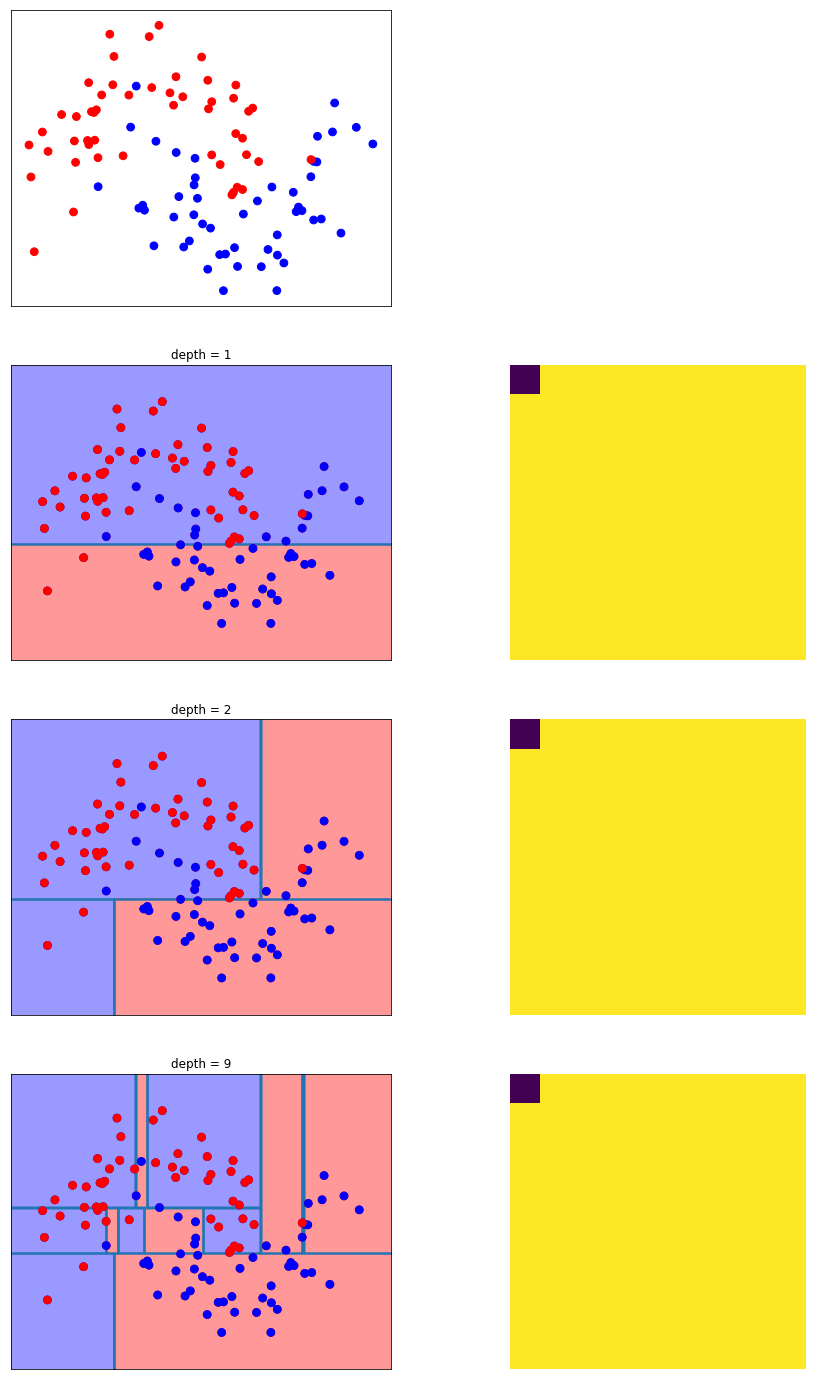

In [2]:
mglearn.plot_interactive_tree.plot_tree_progressive()

Let's try to use a decision tree to model survival from the Titanic.

In [3]:
titanic = pd.read_csv('data/titanic.csv').dropna()
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


Like Naive Bayes models we need to encode categorical features as True/False.

In [4]:
features = ['class', 'age', 'deck', 'survived']
titanic_dummies = pd.get_dummies(titanic[features])
titanic_dummies.head()

,age,survived,class_First,class_Second,class_Third,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
1,38.0,1,1,0,0,0,0,1,0,0,0,0
3,35.0,1,1,0,0,0,0,1,0,0,0,0
6,54.0,0,1,0,0,0,0,0,0,1,0,0
10,4.0,1,0,0,1,0,0,0,0,0,0,1
11,58.0,1,1,0,0,0,0,1,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(titanic_dummies, random_state=0)

features = titanic_dummies.columns.drop('survived')

X_train = train[features]
X_test = test[features]
y_train = train['survived']
y_test = test['survived']

In [6]:
from sklearn.tree import DecisionTreeClassifier

The most important feature of a decision tree is the `max_depth`.

A decision tree with a large `max_depth`, while capable of defining every observation, is by definition *overfitted.*

In [7]:
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.6739130434782609

## Important features

By asking only three independent questions we can see which three features have most *decisive power*.

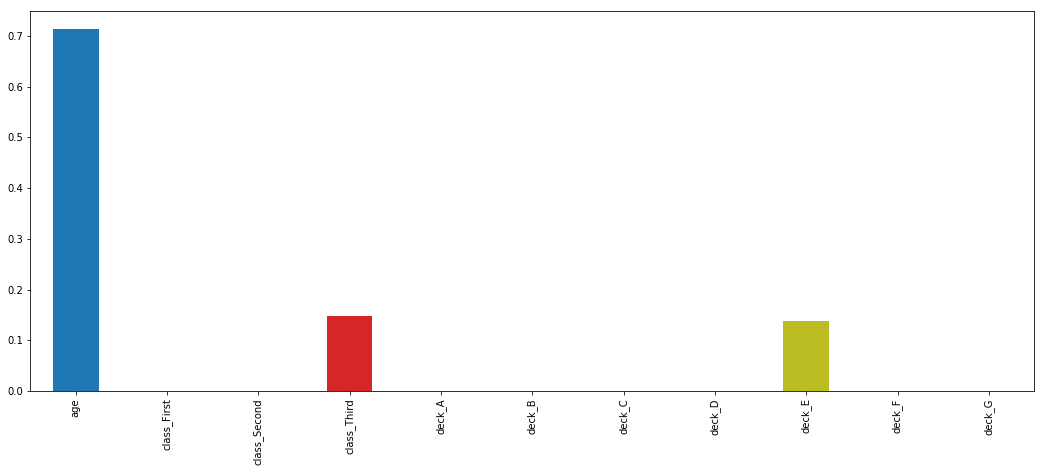

In [8]:
pd.Series(tree.feature_importances_, index=features).plot.bar(figsize=(18,7))

## Visualization

In [10]:
from sklearn.tree import export_graphviz
import sys, subprocess
from IPython.display import Image

export_graphviz(tree, feature_names=features, class_names=['dead','alive'],
                out_file='tmp/titanic.dot', impurity=False, filled=True)
subprocess.check_call([sys.prefix+'/bin/dot','-Tpng','tmp/titanic.dot','-o','tmp/titanic.png'])
Image('tmp/titanic.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified

# Predict salaries

Given a collection of demographic information. What are the most important features to predict whether someone makes more than $50,000 per year?

In [20]:
salaries = pd.read_csv('data/adult.csv', index_col=0)
salaries.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
salaries_dummies = pd.get_dummies(salaries).drop('income_ <=50K', axis='columns')
features = salaries_dummies.columns.drop('income_ >50K')

train, test = train_test_split(salaries_dummies, random_state=0)

X_train = train[features]
X_test = test[features]
y_train = train['income_ >50K']
y_test = test['income_ >50K']

Let's overfit a Decision Tree.

In [13]:
tree = DecisionTreeClassifier(max_depth=None, random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

The model is 98% accurate on the *training data*

In [14]:
tree.score(X_train, y_train)

0.9794840294840295

But 81% accurate on the testing data.

In [15]:
tree.score(X_test, y_test)

0.8157474511730746

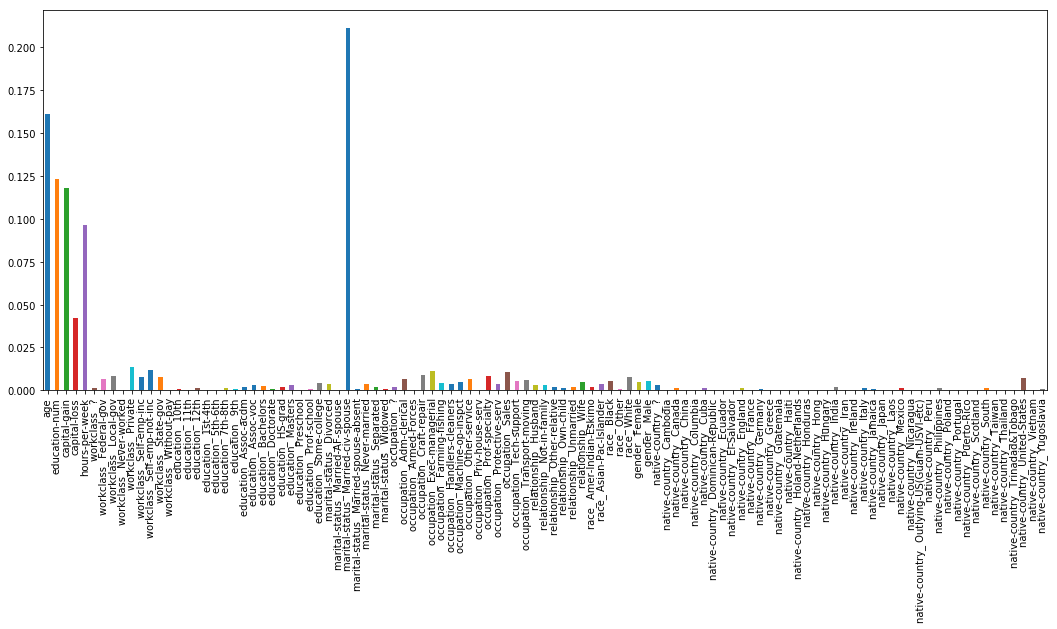

In [16]:
pd.Series(tree.feature_importances_, index=X_train.columns).plot.bar(figsize=(18,7))

# Ensembles of trees

Ensemble models help reduce the effects of overfitting a single decision tree by creating an ensemble of *slightly different* decision trees.

* Trees can differ by
  * the subset of training data used to train
  * the subset of features used to train

## Random forest

Random forests build independent decision trees and by default each tree is given a random subset of the training data.

In [17]:
from sklearn.ensemble import RandomForestClassifier

`n_estimators` is total number of trees to fit. Here we'll let all of the Decision Trees overfit.

With this we get a test score slightly higher.

In [56]:
rnd = RandomForestClassifier(n_estimators=5,
                             max_depth=10,
                             random_state=0)

rnd.fit(X_train, y_train)
print('Training {}'.format(rnd.score(X_train, y_train)))
print('Testing  {}'.format(rnd.score(X_test, y_test)))

Training 0.8584357084357085
Testing  0.8514924456454981


### Feature importance

Ensemble methods are generally more stable than decision trees and as such the feature importance is highly reliable.

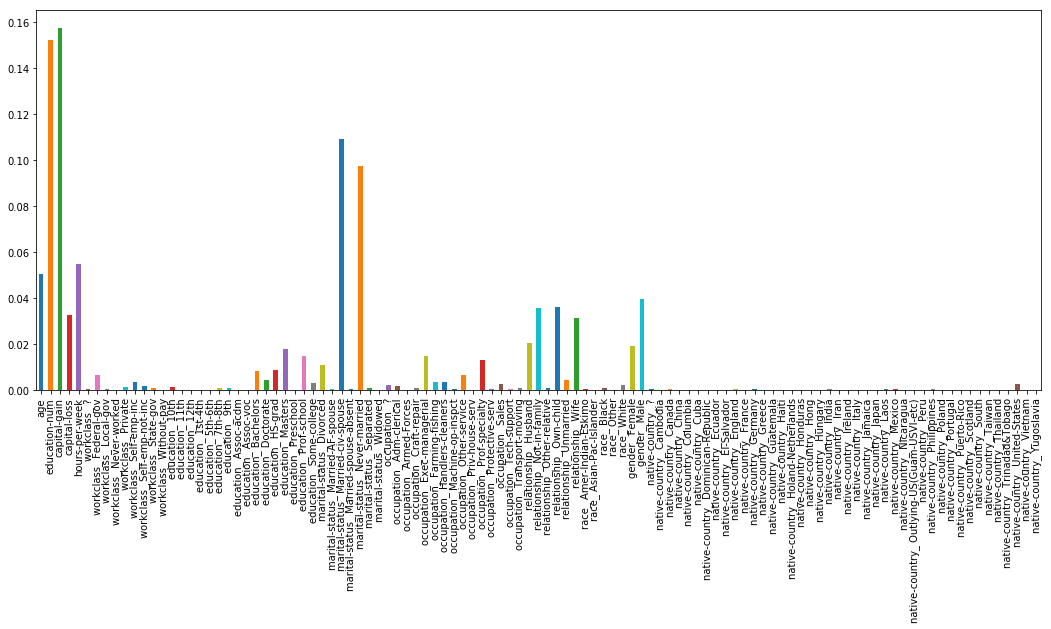

In [57]:
pd.Series(rnd.feature_importances_, index=X_train.columns).plot.bar(figsize=(18,7));

## Gradient Boosting

Gradient Boosting trees are built sequentially by correcting mistakes from the previous tree.

In Gradient Boosting each tree must be pre-pruned.

Caution: Gradient Boosting models can be slow to train.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

Like trees and forests `max_depth` controls the number of decision layers in each tree.

The `learning_rate` argument controls the strength of the corrects to each sequential tree.
* higher `learning_rate` can lead to a complex model and overfitting 
* lower `learning_rate` can lead to a general model and underfitting

The `n_estimators` parameter defaults to 100 trees.

In [61]:
gb = GradientBoostingClassifier(max_depth=2, learning_rate=0.01, n_estimators=100, random_state=0)

gb.fit(X_train, y_train)
print('Training {}'.format(gb.score(X_train, y_train)))
print('Testing  {}'.format(gb.score(X_test, y_test)))

Training 0.7983210483210483
Testing  0.7935143102812923


By changing max_depth, learning_rate and n_estimators we can improve the scores.

Caution: Gradient Boosting models can be sensitive to small changes in these parameters.

In [ ]:
gb = GradientBoostingClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=0)

gb.fit(X_train, y_train)
print('Training {}'.format(gb.score(X_train, y_train)))
print('Testing  {}'.format(gb.score(X_test, y_test)))

### Important features

In [ ]:
pd.Series(gb.feature_importances_, index=X_train.columns).plot.bar(figsize=(18,7))

## Ranking features

The forest of simple trees helps reduce overfitting, but the decisions are less easy to understand since the decision boundaries are determined by *soft voting* where regions overlap.

In [ ]:
pd.Series(rnd.feature_importances_, index=X_train.columns).plot.bar(figsize=(18,7))

# Regression problems

Decision trees are built by making divisions along a feature 

The dividing lines are optimized to reduce prediction errors to the training values.

These separate dividing lines allow for *non-linear* responses to be trained.

In [ ]:
auto = pd.read_csv('data/auto-mpg.csv')
auto.head()

In [ ]:
X = auto[['cyl','displ','hp','weight','accel']]
y = auto['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**Caution**

Decision tree regressors cannot *extrapolate* data. They are best used to predict new values within the range of training features.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor(random_state=0, max_depth=2)

features = ['hp']

tree.fit(X_train[features], y_train)
tree.score(X_test[features], y_test)

The terminal leaves in the graph show the target value associated with each decision path.

The predicted value of the region for each terminal leaf is the mean value of the training target.

In [ ]:
export_graphviz(tree, feature_names=features,
                out_file='tmp/auto.dot', impurity=False, filled=True)
subprocess.check_call([sys.prefix+'/bin/dot','-Tpng','tmp/auto.dot','-o','tmp/auto.png'])
Image('tmp/auto.png')

## Complexity vs generality

As the max_depth increases the model can easily *memorize* the training data and become incapable of making accurate predictions over the test data.

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20,8))

for ax, depth in zip(axes, [2, 4, 8]):
    tree = DecisionTreeRegressor(random_state=0, max_depth=depth)
    
    tree.fit(X_train[['hp']], y_train)
    tree.score(X_test[['hp']], y_test)
    
    auto.plot.scatter(x='hp', y='mpg', ax=ax)
    s = X.sort_values('hp')
    ax.plot(s['hp'], tree.predict(s[['hp']]), c='red')
    ax.set_title('max_depth={}'.format(depth))

## Ensembles

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

In [ ]:
houses = pd.DataFrame(boston.data, columns=boston.feature_names)
houses['price'] = boston.target

X = houses.drop('price',axis='columns')
y = houses['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

When training on multiple features a division is made in only one dimension at a time.

This can be used to aid in *feature selection*.

This model is intentionally overfit.

In [ ]:
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

The relative *importance* of a feature is a measure of its predictive power.

**Caution**

In the case of co-linear features only one will be usually have a high important since adding a decision node in the second feature makes little difference.

In [ ]:
pd.Series(tree.feature_importances_, index=boston.feature_names).plot.bar(figsize=(18,7))

The Random Forest improves the accuracy without having to aggressively tune parameters.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rnd = RandomForestRegressor(n_estimators=10, random_state=0)
rnd.fit(X_train, y_train)
rnd.score(X_test, y_test)

In [ ]:
pd.Series(rnd.feature_importances_, index=boston.feature_names).plot.bar(figsize=(18,7))

And finally Gradient Boosting has improved the score a bit further.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=0)
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)

In [ ]:
pd.Series(gbr.feature_importances_, index=boston.feature_names).plot.bar(figsize=(18,7))

<img src='img/copyright.png'>